## In this attempt I tried reducing the convolution filters size and increased the latent space to 16 dimensions, the results were better than the previous model as they were sharp as well as they were able to correctly decode the input, it was successful in decoding very hard samples like the ones in 12th and 14th column

## This model has better results than compared to the previous model even though it has just 200k params and the earlier model had 300k params.

## Imports

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [ ]:
from helper_data import get_dataloaders_mnist
from helper_train import train_autoencoder_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels

In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 3
NUM_CLASSES = 10
DEVICE = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 10

Device: cuda:0


In [ ]:

set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [ ]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    num_workers=2,
    validation_fraction=0.)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 16, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(16, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(64 * 7 * 7, 16)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(16, 64 * 7 * 7),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 16, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(16, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
set_all_seeds(RANDOM_SEED)

In [ ]:
model = AutoEncoder()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

223889

## Training

In [ ]:
log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model,
                                optimizer=optimizer, device=DEVICE,
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Epoch: 001/010 | Batch 0000/1875 | Loss: 0.1902
Epoch: 001/010 | Batch 0250/1875 | Loss: 0.0525
Epoch: 001/010 | Batch 0500/1875 | Loss: 0.0238
Epoch: 001/010 | Batch 0750/1875 | Loss: 0.0156
Epoch: 001/010 | Batch 1000/1875 | Loss: 0.0169
Epoch: 001/010 | Batch 1250/1875 | Loss: 0.0143
Epoch: 001/010 | Batch 1500/1875 | Loss: 0.0117
Epoch: 001/010 | Batch 1750/1875 | Loss: 0.0117
Time elapsed: 0.89 min
Epoch: 002/010 | Batch 0000/1875 | Loss: 0.0136
Epoch: 002/010 | Batch 0250/1875 | Loss: 0.0111
Epoch: 002/010 | Batch 0500/1875 | Loss: 0.0117
Epoch: 002/010 | Batch 0750/1875 | Loss: 0.0106
Epoch: 002/010 | Batch 1000/1875 | Loss: 0.0100
Epoch: 002/010 | Batch 1250/1875 | Loss: 0.0101
Epoch: 002/010 | Batch 1500/1875 | Loss: 0.0090
Epoch: 002/010 | Batch 1750/1875 | Loss: 0.0109
Time elapsed: 1.72 min
Epoch: 003/010 | Batch 0000/1875 | Loss: 0.0094
Epoch: 003/010 | Batch 0250/1875 | Loss: 0.0096
Epoch: 003/010 | Batch 0500/1875 | Loss: 0.0102
Epoch: 003/010 | Batch 0750/1875 | Loss: 0

## Evaluation

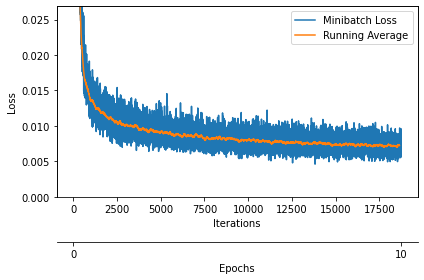

In [ ]:
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

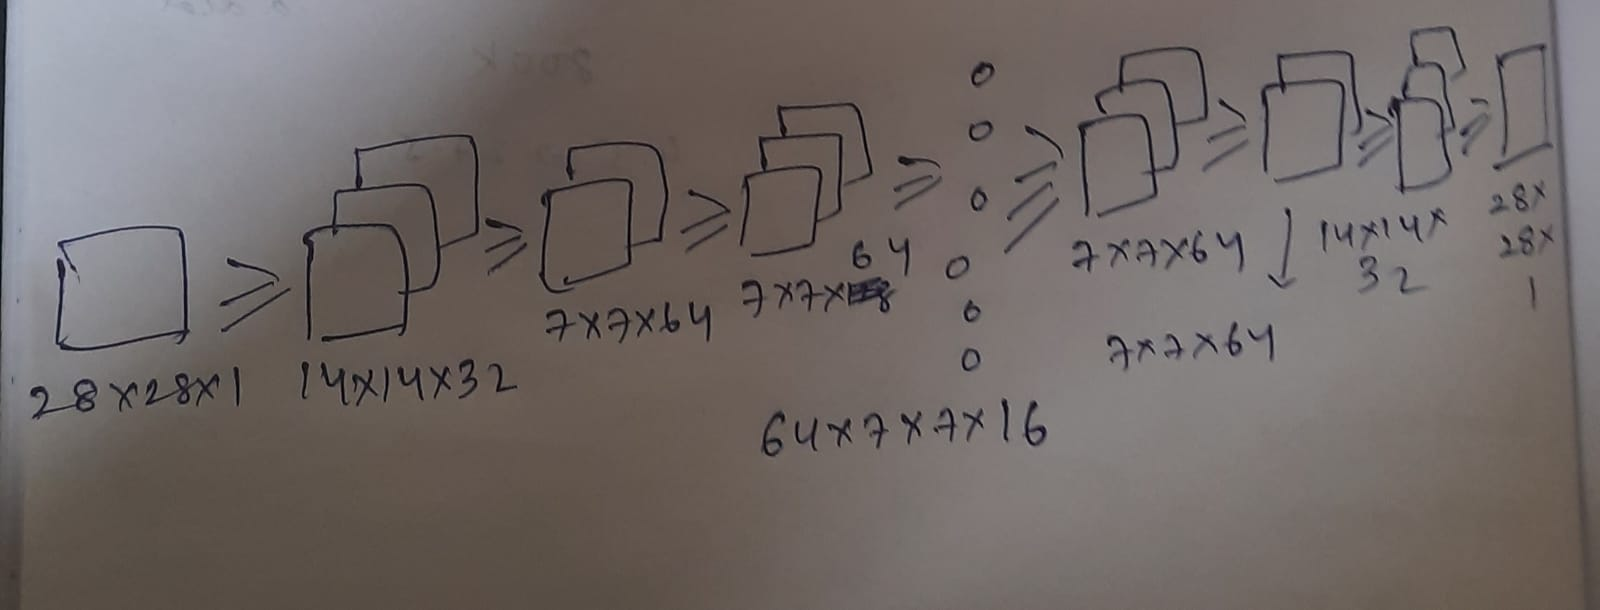

## This model with 16 dimension latent space

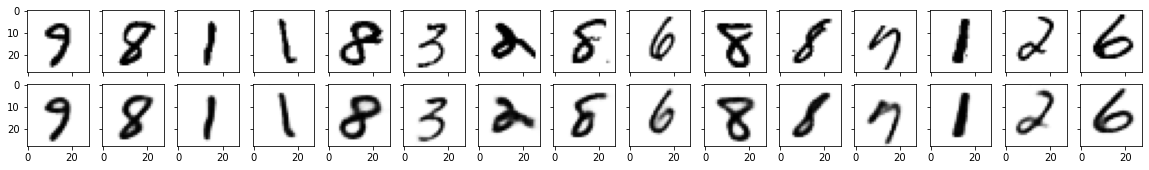

In [ ]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)

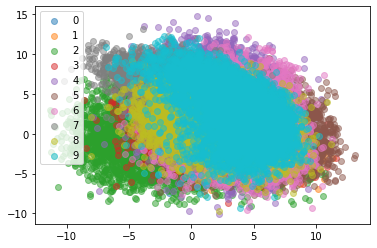

In [ ]:
plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    model=model,
    device=DEVICE)

plt.legend()
plt.show()

## Decoding one particular image and a new image (Not part of exercise)

In [ ]:
sample_img = None
sample_labels = None
for images, labels in train_loader:
    sample_img = images
    sample_labels = labels
    break

In [ ]:
sample_img = sample_img.to(DEVICE)
encoded_sample =  model.encoder(sample_img)

In [ ]:
len(encoded_sample)

32

In [ ]:
len(encoded_sample[7])

16

In [ ]:
sample_labels[7]

tensor(4)

In [ ]:
encoded_sample[7]

tensor([ 2.0732,  6.0997,  2.0306,  0.4322,  3.8104,  3.7257,  7.4104, -2.4846,
         5.6626, -1.5646, -7.7405,  7.4450,  2.5906, -1.8175, -4.4246, -3.3760],
       device='cuda:0', grad_fn=<SelectBackward0>)

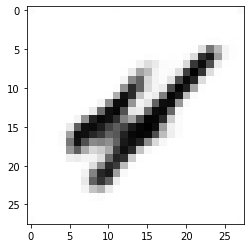

In [ ]:
with torch.no_grad():
    new_image = model.decoder(encoded_sample[7].to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

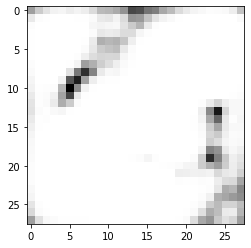

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.9530,  4.7536, -1.7579,  2.1931,  1.6892,  0.1474, -0.9897, -0.8492,
        -5.8476, -2.1962,  5.0543, -7.7104, -8.0243,  0.0736,  5.2480,  7.1616]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

# Final thoughts - I feel the more number of convoluted paremeters the worse becomes the performance of the autoencoder and the more the nerons in latent space the better the performance gets.

# If I had to solve this kind of a problem in the future, I would use fewer Convoluted layers and more neurons in the latent space.

## Answer 2 - Adding noise and comparing the output

In [ ]:
import numpy as np
noise_factor = 0.2

In [ ]:
def generate_and_plot_noisy_data(noise_factor=0.2):
  fig, axes = plt.subplots(2, 10,figsize=(20, 2.5))
  fig.tight_layout()
  for images, labels in test_loader:
      sample_test_images = images[:10]
      noisy_imgs = sample_test_images + noise_factor * torch.randn(*sample_test_images.shape)
      noisy_imgs = np.clip(noisy_imgs, 0., 1.)
      labels = labels[:10]

      for idx, label in enumerate(labels):
        print(f"Label : {label}")
        with torch.no_grad():

          sample_test_images = sample_test_images.to(DEVICE)
          encoded_sample_test_images =  model.encoder(sample_test_images)


          new_image = model.decoder(encoded_sample_test_images[idx].to(DEVICE))
          new_image.squeeze_(0)
          new_image.squeeze_(0)
          axes[0][idx].imshow(new_image.to('cpu').numpy(), cmap='binary')

          # ------ Noisy Data -------- #
          noisy_imgs = noisy_imgs.to(DEVICE)
          encoded_noisy_imgs =  model.encoder(noisy_imgs)


          noisy_image = model.decoder(encoded_noisy_imgs[idx].to(DEVICE))
          noisy_image.squeeze_(0)
          noisy_image.squeeze_(0)
          axes[1][idx].imshow(noisy_image.to('cpu').numpy(), cmap='binary')
      break


Label : 7
Label : 2
Label : 1
Label : 0
Label : 4
Label : 1
Label : 4
Label : 9
Label : 5
Label : 9


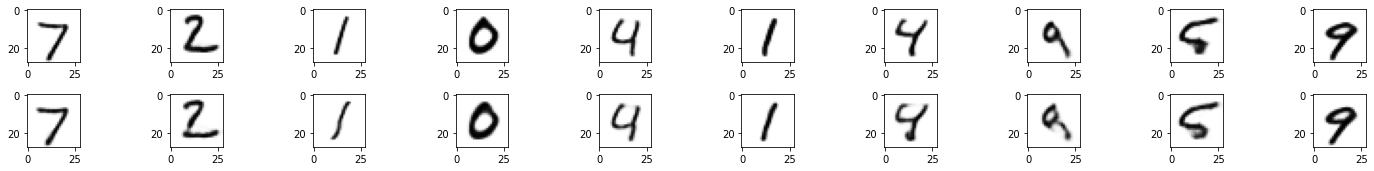

In [ ]:
generate_and_plot_noisy_data()

Label : 7
Label : 2
Label : 1
Label : 0
Label : 4
Label : 1
Label : 4
Label : 9
Label : 5
Label : 9


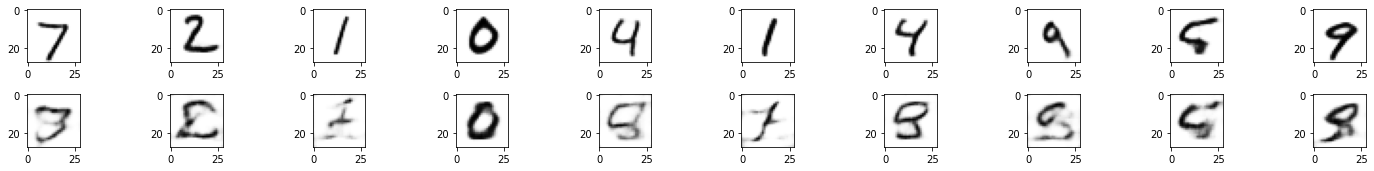

In [ ]:
generate_and_plot_noisy_data(0.4)

## We can see that, wight a noise factor of 0.2 the model was able to decode the noisy images fairly efficeintly whereas the with noise factor of 0.4, there were a lot of distortions to the generated images.